# Import PRAW for data extraction from the Reddit

In [13]:
!pip install praw

  Obtaining dependency information for praw from https://files.pythonhosted.org/packages/73/ca/60ec131c3b43bff58261167045778b2509b83922ce8f935ac89d871bd3ea/praw-7.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for prawcore<3,>=2.4 from https://files.pythonhosted.org/packages/96/5c/8af904314e42d5401afcfaff69940dc448e974f80f7aa39b241a4fbf0cf1/prawcore-2.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for update_checker>=0.18 from https://files.pythonhosted.org/packages/0c/ba/8dd7fa5f0b1c6a8ac62f8f57f7e794160c1f86f31c6d0fb00f582372a3e4/update_checker-0.18.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/189.3 kB ? eta -:--:--
   ------ --------------------------------- 30.7/189.3 kB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 122.9/189.3 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 189.3/189.3 kB 1.6 MB/s eta 0:00:00


# Extracting the data from the Reddit

In [57]:
import warnings
warnings.filterwarnings("ignore")
import praw
import pandas as pd

# Initialize Reddit API client
reddit = praw.Reddit(
    client_id="mTrVr9hxekZC8fH1cUL1iA",
    client_secret="wVTJsGPO_0EF_pc_9stzMTTpxDBqwg",
    user_agent="Test"
)


def scrape_reddit_paginated(subreddit_name, max_posts=1000):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    after = None
    count = 0

    while count < max_posts:
        for post in subreddit.hot(limit=None, params={'after': after}):
            posts.append({
                'Title': post.title,
                'Text': post.selftext,
                'Score': post.score,
                'Upvote_Ratio': post.upvote_ratio,
                'Comments': post.num_comments,
                'Created': pd.to_datetime(post.created_utc, unit='s'),
            })
            count += 1
            if count >= max_posts:
                break
        after = post.id  # Update the pagination marker

    return pd.DataFrame(posts)

# Example usage
df_reddit = scrape_reddit_paginated('stocks', max_posts=1500)
print(df_reddit.shape)

(1500, 6)


In [58]:
df_reddit

,Title,Text,Score,Upvote_Ratio,Comments,Created
0,Rate My Portfolio - r/Stocks Quarterly Thread ...,Please use this thread to discuss your portfol...,9,0.77,77,2024-12-01 10:00:22
1,r/Stocks Daily Discussion & Technicals Tuesday...,"This is the daily discussion, so anything stoc...",5,0.86,82,2024-12-03 10:30:10
2,Tesla CEO Elon Musk loses bid to get $56 billi...,"A Delaware judge ruled on Monday that Tesla, C...",4638,0.91,793,2024-12-02 22:10:38
3,Palantir Granted FedRAMP High Baseline Authori...,>Palantir Technologies Inc. (NASDAQ: PLTR) tod...,32,0.88,5,2024-12-03 14:46:49
4,Rivian's potential $6.6 billion DoE loan catch...,[Rivian's potential $6.6 billion DoE loan catc...,394,0.88,128,2024-12-02 23:11:19
...,...,...,...,...,...,...
1495,Microsoft faces wide-ranging U.S. antitrust probe,The U.S. Federal Trade Commission has opened a...,186,0.95,87,2024-11-28 01:38:14
1496,r/Stocks Daily Discussion & Options Trading Th...,"This is the daily discussion, so anything stoc...",7,0.89,74,2024-11-28 10:30:09
1497,I don't understand MicroStrategy,"It has 386,700 biiitttcoin which is approx. $3...",403,0.86,389,2024-11-27 12:29:35
1498,Why I think UBER is a BUY,**Personal trading context:**\n\nI do not look...,0,0.25,54,2024-11-29 12:32:18


# Importing all the required resources

In [59]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Bharath\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

  # Data Preprocessing and Intializing the Sentiment Intensity 

In [77]:
import pandas as pd
# Function to scale numeric columns
def scale_numeric_columns(df, columns):
    """Scale specified numerical columns to a range of [0, 1]."""
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

# Text preprocessing function
def preprocess_text(text):
    words = word_tokenize(text)
    cleaned_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words and word.isalpha()]
    return " ".join(cleaned_words)

# Function to process datetime column
def preprocess_datetime_column(df, column_name):
    """Convert datetime column to datetime object and extract useful features."""
    df[column_name] = pd.to_datetime(df[column_name])  # Convert to datetime
    df['created_day'] = df[column_name].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    df['created_hour'] = df[column_name].dt.hour  # Hour of the day
    return df

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# Function to classify sentiment
def classify_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Preprocessing steps for df_reddit
# Combine 'Title' and 'Text' columns
df_reddit['combined_text'] = df_reddit['Title'] + " " + df_reddit['Text']
df_reddit['combined_text'] = df_reddit['combined_text'].apply(preprocess_text)  # Preprocess combined text

# Scale numerical columns
numeric_columns = ['Score', 'Upvote_Ratio', 'Comments']
df_reddit = scale_numeric_columns(df_reddit, numeric_columns)

# Process 'Created' column
df_reddit = preprocess_datetime_column(df_reddit, 'Created')

# Classify sentiment
df_reddit['sentiment'] = df_reddit['combined_text'].apply(classify_sentiment)

In [78]:
df_reddit

,Title,Text,Score,Upvote_Ratio,Comments,Created,combined_text,created_day,created_hour,sentiment,preprocessed_text
0,Rate My Portfolio - r/Stocks Quarterly Thread ...,Please use this thread to discuss your portfol...,0.001935,0.732558,0.029973,2024-12-01 10:00:22,rate portfolio quarterly thread december pleas...,6,10,Positive,please use thread discus portfolio learn stock...
1,r/Stocks Daily Discussion & Technicals Tuesday...,"This is the daily discussion, so anything stoc...",0.001075,0.837209,0.031919,2024-12-03 10:30:10,daily discussion technical tuesday dec daily d...,1,10,Positive,daily discussion anything stock related fine t...
2,Tesla CEO Elon Musk loses bid to get $56 billi...,"A Delaware judge ruled on Monday that Tesla, C...",0.997205,0.895349,0.308680,2024-12-02 22:10:38,tesla ceo elon musk loses bid get billion pay ...,0,22,Positive,delaware judge ruled monday tesla ceo elon mus...
3,Palantir Granted FedRAMP High Baseline Authori...,>Palantir Technologies Inc. (NASDAQ: PLTR) tod...,0.006880,0.860465,0.001946,2024-12-03 14:46:49,palantir granted fedramp high baseline authori...,1,14,Positive,palantir technology nasdaq pltr today announce...
4,Rivian's potential $6.6 billion DoE loan catch...,[Rivian's potential $6.6 billion DoE loan catc...,0.084713,0.860465,0.049825,2024-12-02 23:11:19,rivian potential billion doe loan catch eye do...,0,23,Positive,rivian potential billion doe loan catch eye do...
...,...,...,...,...,...,...,...,...,...,...,...
1495,Microsoft faces wide-ranging U.S. antitrust probe,The U.S. Federal Trade Commission has opened a...,0.039991,0.941860,0.033865,2024-11-28 01:38:14,microsoft face antitrust probe federal trade c...,3,1,Positive,federal trade commission opened broad antitrus...
1496,r/Stocks Daily Discussion & Options Trading Th...,"This is the daily discussion, so anything stoc...",0.001505,0.872093,0.028805,2024-11-28 10:30:09,daily discussion option trading thursday nov d...,3,10,Positive,daily discussion anything stock related fine t...
1497,I don't understand MicroStrategy,"It has 386,700 biiitttcoin which is approx. $3...",0.086648,0.837209,0.151421,2024-11-27 12:29:35,understand microstrategy biiitttcoin approx bi...,2,12,Negative,biiitttcoin approx billion market cap billion ...
1498,Why I think UBER is a BUY,**Personal trading context:**\n\nI do not look...,0.000000,0.127907,0.021020,2024-11-29 12:32:18,think uber buy personal trading context look b...,4,12,Positive,personal trading context look balance sheet ev...


# Data Visualization of Sentiment Distribution

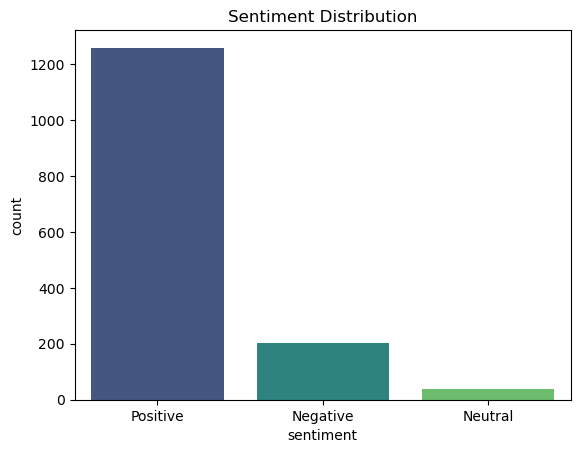

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualize sentiment distribution
sns.countplot(data=df_reddit, x='sentiment', palette='viridis')
plt.title('Sentiment Distribution')
plt.show()

# Spliting the data into Test and Train 

In [80]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = df_reddit['combined_text']
y = df_reddit['sentiment']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 1200, Test size: 300


# Implementing the Machine Learning Algorithms

Naive Bayes

Accuracy: 0.9633333333333334
Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.83      0.90        46
     Neutral       1.00      0.25      0.40         4
    Positive       0.96      1.00      0.98       250

    accuracy                           0.96       300
   macro avg       0.99      0.69      0.76       300
weighted avg       0.96      0.96      0.96       300



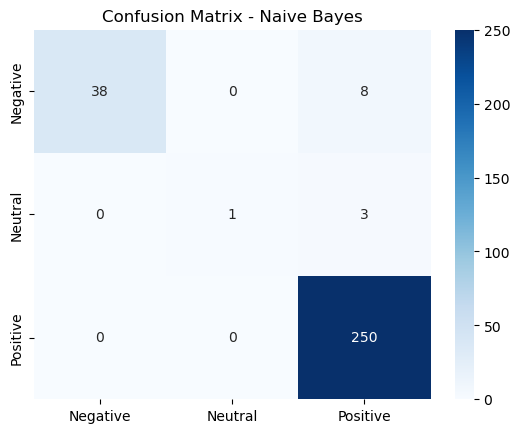

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convert text data into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = nb_model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

Logistic Regression

Logistic Regression Accuracy: 1.0
Classification Report - Logistic Regression:
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        46
     Neutral       1.00      1.00      1.00         4
    Positive       1.00      1.00      1.00       250

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



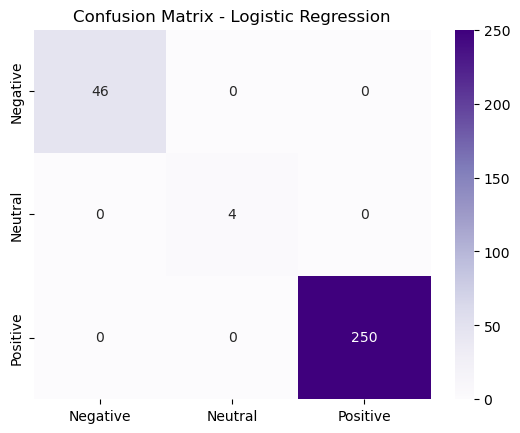

In [88]:
from sklearn.linear_model import LogisticRegression
# Train Logistic Regression
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train_tfidf, y_train)

# Predict using Logistic Regression
y_pred_logreg = log_reg_model.predict(X_test_tfidf)

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report - Logistic Regression:\n", classification_report(y_test, y_pred_logreg))

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [101]:
def predict_sentiment(text):
    """Predict the sentiment of a new text input and provide the corresponding action (Going Up/Down/Neutral)."""
    cleaned_text = preprocess_text(text)  # Preprocess the new text
    vectorized_text = vectorizer.transform([cleaned_text])  # Vectorize the new text
    prediction = nb_model.predict(vectorized_text)  # Predict sentiment
    
    # Map sentiment to action
    if prediction[0] == 'Positive':
        return 'Going Up'
    elif prediction[0] == 'Negative':
        return 'Going Down'
    else:
        return 'Neutral'

# Example use: Predict sentiment for a new text input
new_text = "I think this company is doing really well!"
predicted_action = predict_sentiment(new_text)
print(f"Predicted Action: {predicted_action}")

Predicted Action: Going Up
